In [1]:
%load_ext autoreload
%autoreload 2

import torch
from torch import nn
import torchvision.datasets as datasets
import torchvision.models as models
import torch.optim as optim
from torch.utils.data import DataLoader

import seaborn as sns

import sys
sys.path.append('./python_files/')
import pickle

from model_trainer import ModelTrainer
from utils import *
from data_loader import *
from nn_modules import View
from nn_models import *

In [2]:
print("pytorch version: ",torch.__version__)

pytorch version:  1.0.0


In [3]:
if torch.cuda.is_available():
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
    print("Using GPU: ",torch.cuda.get_device_name(0))

Using GPU:  GeForce GTX 1080 Ti


## 0) Loading the data (MNIST or CIFAR-10)

In [223]:
train_input_full, train_target_full, test_input_full, test_target_full = load_data(cifar=False, normalize=True, flatten=False, full=True)

train_target_full = train_target_full.long()
test_target_full = test_target_full.long()

* Using MNIST
** Use 60000 train and 10000 test samples


In [224]:
print("shape of training samples :", train_input_full.shape)

shape of training samples : torch.Size([60000, 1, 28, 28])


In [259]:
nb_sample = 60000
train_input = train_input_full[0:nb_sample]
train_target = train_target_full[0:nb_sample]

test_input = test_input_full[0:nb_sample]
test_target = test_target_full[0:nb_sample]

In [260]:
print("shape of training samples :", train_input.shape)
print("shape of testing samples :", test_input.shape)

shape of training samples : torch.Size([60000, 1, 28, 28])
shape of testing samples : torch.Size([10000, 1, 28, 28])


In [261]:
computeClassesWeights(train_target)

tensor([0.0987, 0.1124, 0.0993, 0.1022, 0.0974, 0.0904, 0.0986, 0.1044, 0.0975,
        0.0992])

In [262]:
computeClassesWeights(test_target)

tensor([0.0980, 0.1135, 0.1032, 0.1010, 0.0982, 0.0892, 0.0958, 0.1028, 0.0974,
        0.1009])

## 1) LeNet with disjoint trainset and testset (train 10 shadow models)

In [263]:
train_dataset = (train_input, train_target)
test_dataset = (test_input, test_target)

In [264]:
crossEntropyClassesWeigths = computeClassesWeights(train_target)

In [265]:
load_from_memory = True

In [266]:
size_input_vector = train_dataset[0].shape

In [267]:
if not load_from_memory:
    shadow_models = list()
    nb_shadow_models = 100

    (shadow_train_datasets, shadow_test_datasets) = \
        generate_n_shadow_models_datasets(nb_shadow_models, train_dataset, test_dataset)

    for i in range(nb_shadow_models):
        print("training model", i)
        shadow_models.append(shadow_model(size_input_vector))#LeoNet())

        crit_fun = lambda input_, target : (input_, target)
        y_hat_fun = lambda y: y.argmax(1)

        loss_fun = nn.CrossEntropyLoss()
        learning_rate = 0.1

        mt = ModelTrainer(shadow_models[i], loss_fun, optim.SGD(shadow_models[i].parameters(), lr=learning_rate), y_hat_fun, crit_fun)
        hist = mt.fit(shadow_train_datasets[i], shadow_test_datasets[i], epochs=300, batch_size=500, verbose=0)
        #mt.plot_training("Learning curves")

In [268]:
if not load_from_memory:
    for i in range(nb_shadow_models):
        save_model_state(shadow_models[i], 'shadow_models/shadow_model_'+str(i)+'_F.pickle')

In [269]:
if load_from_memory:
        
    shadow_models = list()
    nb_shadow_models = 100

    (shadow_train_datasets, shadow_test_datasets) = \
        generate_n_shadow_models_datasets(nb_shadow_models, train_dataset, test_dataset)
    
    for i in range(nb_shadow_models):
        shadow_models.append(LeoNet())
        
    for i in range(nb_shadow_models):
        load_model_state(shadow_models[i], 'shadow_models/shadow_model_'+str(i)+'_F.pickle')

In [270]:
shadow_train_datasets[0][0].shape

torch.Size([600, 1, 28, 28])

## 2) Train G with shadow models (Dense layers)

In [271]:
for i in range(nb_shadow_models):
    shadow_models[i].eval()

In [272]:
shadow_models[0]

LeoNet(
  (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
  (mxp1): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (view): View(_, [-1])
  (fc1): Linear(in_features=576, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=10, bias=True)
)

In [273]:
layers = list()
layer_names = list()

for i in range(nb_shadow_models):
    layers.append(shadow_models[i].view)
    layer_names.append("shadow_model["+str(i)+"].view")

In [274]:
layers[5]

View(_, [-1])

In [275]:
g_shadow_train_datasets, g_shadow_test_datasets = \
generate_dataset_g_per_class_from_shadows(shadow_models, shadow_train_datasets, shadow_test_datasets, layers, layer_names, split=0.8, nb_class=10)

In [276]:
g_shadow_test_datasets[0][1].shape

torch.Size([1462])

In [277]:
choosen_class = 0
g_shadow_train_dataset = g_shadow_train_datasets[choosen_class]
g_shadow_test_dataset = g_shadow_test_datasets[choosen_class]

g_shadow_train_dataset, g_shadow_test_dataset = normalize_data(g_shadow_train_dataset, g_shadow_test_dataset)

In [278]:
size_input_vector = g_shadow_train_dataset[0].shape
print("size of layer vector :", size_input_vector)
flattened_size = np.prod(np.array(g_shadow_train_dataset[0].shape[1:]))
print("size of flattened input (1 sample):", flattened_size)

size of layer vector : torch.Size([5441, 1, 576])
size of flattened input (1 sample): 576


In [279]:
g_shadow_target_weigths = torch.abs(1-computeClassesWeights(g_shadow_train_dataset[1]))
g_shadow_target_weigths# = torch.Tensor([0.90, 0.1])

tensor([0.8638, 0.1362])

In [280]:
def denseG(vector_size):
    model = nn.Sequential(
        View([-1]),
        nn.Linear(vector_size, 256),
        nn.ReLU(),
        nn.BatchNorm1d(256),
        nn.Dropout(0.5),

        nn.Linear(256, 128),
        nn.ReLU(),
        nn.BatchNorm1d(128),
        nn.Dropout(0.5),
        
        nn.Linear(128, 64),
        nn.ReLU(),
        nn.BatchNorm1d(64),
        nn.Dropout(0.3),
        
        nn.Linear(64, 32),
        nn.ReLU(),
        nn.BatchNorm1d(32),
        
        nn.Linear(32, 16),
        nn.ReLU(),
        nn.BatchNorm1d(16),
        
        nn.Linear(16, 2),
        nn.Softmax(1)
    )
    return model

def small_denseG(vector_size):
    model = nn.Sequential(
        View([-1]),
        nn.Linear(vector_size, 2),
        nn.ReLU(),
        nn.BatchNorm1d(2),
        
        nn.Linear(2, 2),
    )
    return model

In [281]:
sufix = "denseG_MNIST_output"

CRITICAL:root:Cannot load caffe2.python. Error: /opt/pytorch/pytorch/torch/lib/python3.6/site-packages/caffe2/python/caffe2_pybind11_state.cpython-36m-x86_64-linux-gnu.so: undefined symbol: _ZN5fLI6438FLAGS_caffe2_max_keep_on_shrink_memoryE


******************************** Train log ************************************
                     train loss       train acc        val loss         val acc
0                    0.69672847           0.507      0.69355816           0.500
100                  0.49509213           0.824      0.63373786           0.640
200                  0.39543381           0.917      0.68003356           0.629
300                  0.37080383           0.944      0.67792159           0.634
400                  0.36499878           0.948      0.70251000           0.616
500                  0.36281674           0.950      0.68755013           0.636
600                  0.35075014           0.962      0.70023572           0.632
700                  0.34433459           0.968      0.70787269           0.622
800                  0.34429263           0.967      0.71612066           0.613
900                  0.34609446           0.966      0.72286087           0.610
1000                 0.34281291         

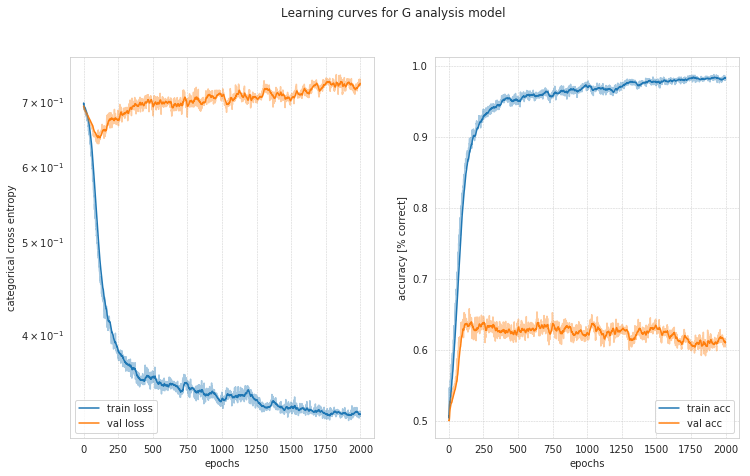

In [282]:
shadow_modelG = denseG(flattened_size)

crit_fun = lambda input_, target : (input_, target)
y_hat_fun = lambda y: y.argmax(1)

loss_fun = nn.CrossEntropyLoss(g_shadow_target_weigths)
learning_rate = 0.05
epochs = 2000

mt = ModelTrainer(shadow_modelG, loss_fun, optim.SGD(shadow_modelG.parameters(), lr=learning_rate), y_hat_fun, crit_fun)
hist = mt.fit(g_shadow_train_dataset, g_shadow_test_dataset, epochs=epochs, batch_size=1000, verbose=epochs/20)
plotted = mt.plot_training("Learning curves for G analysis model")

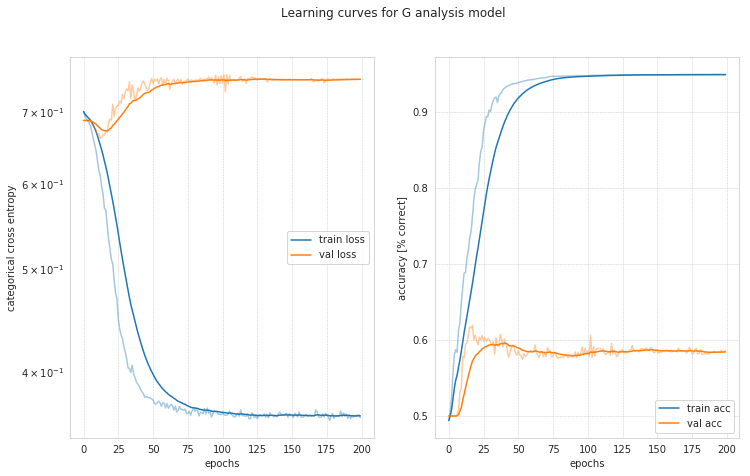

In [96]:
hist.plot("Learning curves for G analysis model")
plt.savefig("G_curve_" + sufix + ".png", dpi=300, bbox_inches='tight')

false negative percentage : 11.774325429272281
false positive percentage : 71.1297071129707


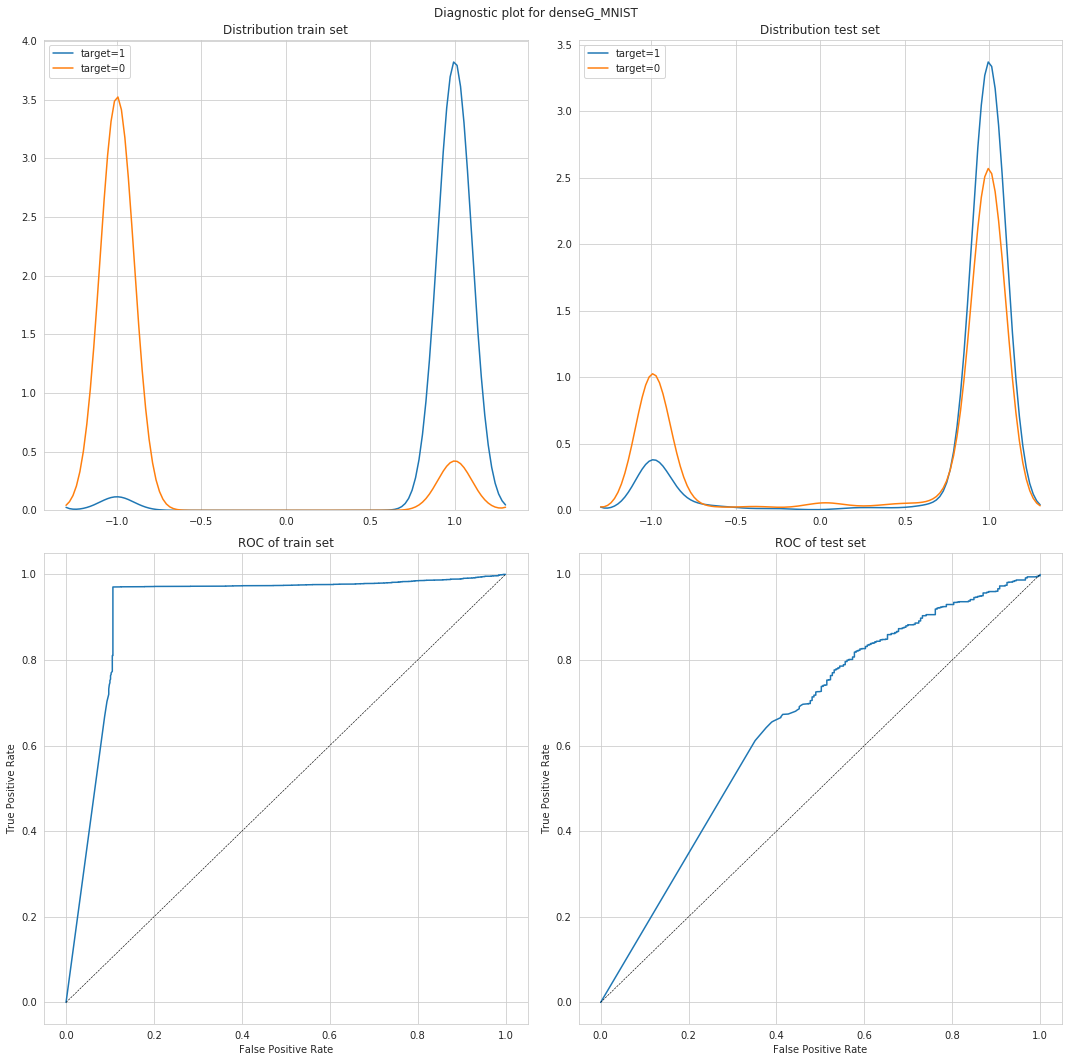


ROC score train : 0.9173362620955008
ROC score test : 0.6551487014919757


In [297]:
diagnostic_plots(shadow_modelG, [g_shadow_train_dataset], [g_shadow_test_dataset], bw=0.1, dataset_name='denseG_MNIST',savefig=False)

## 3) Train G with shadow models (Conv layers)

In [285]:
for i in range(nb_shadow_models):
    shadow_models[i].eval()

In [286]:
shadow_models[0]

LeoNet(
  (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
  (mxp1): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (view): View(_, [-1])
  (fc1): Linear(in_features=576, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=10, bias=True)
)

In [287]:
layers = list()
layer_names = list()

for i in range(nb_shadow_models):
    layers.append(shadow_models[i].conv1)
    layer_names.append("shadow_model["+str(i)+"].conv1")

In [288]:
g_shadow_train_datasets, g_shadow_test_datasets = \
generate_dataset_g_per_class_from_shadows(shadow_models, shadow_train_datasets, shadow_test_datasets, layers, layer_names, split=0.8, nb_class=10)

In [289]:
g_shadow_test_datasets[0][1].shape

torch.Size([1462])

In [290]:
choosen_class = 0
g_shadow_train_dataset = g_shadow_train_datasets[choosen_class]
g_shadow_test_dataset = g_shadow_test_datasets[choosen_class]

g_shadow_train_dataset, g_shadow_test_dataset = normalize_data(g_shadow_train_dataset, g_shadow_test_dataset)

In [291]:
size_input_vector = g_shadow_train_dataset[0].shape
print("size of layer vector :", size_input_vector)

size of layer vector : torch.Size([5441, 1, 16, 24, 24])


In [292]:
g_shadow_target_weigths = torch.abs(1-computeClassesWeights(g_shadow_train_dataset[1]))
g_shadow_target_weigths# = torch.Tensor([0.90, 0.1])

tensor([0.8638, 0.1362])

In [293]:
def kindaResnetG(layer_dim):
    dim = layer_dim[2]
    pad = (1, 1, 1)
    pool = 4
    finalVectorSize = layer_dim[2]//pool * layer_dim[3]//pool * layer_dim[4]//pool
    print(finalVectorSize)
    model = nn.Sequential(
        nn.Conv3d(1, 1, kernel_size=3, padding = pad),
        nn.ReLU(),
        nn.BatchNorm3d(1),
        
        nn.Conv3d(1, 1, kernel_size=3, padding = pad),
        nn.ReLU(),
        nn.BatchNorm3d(1),
        
        nn.Conv3d(1, 1, kernel_size=3, padding = pad),
        nn.ReLU(),
        nn.BatchNorm3d(1),
        nn.MaxPool3d(pool),

        View([-1]),
        nn.Linear(finalVectorSize, 128),
        nn.ReLU(),
        #nn.Linear(64, 128),
        #nn.ReLU(),
        nn.Linear(128, 32),
        nn.ReLU(),
        nn.Linear(32, 16),
        nn.ReLU(),
        nn.Linear(16, 2),
        nn.Softmax(1)
    )
    return model


CRITICAL:root:Cannot load caffe2.python. Error: /opt/pytorch/pytorch/torch/lib/python3.6/site-packages/caffe2/python/caffe2_pybind11_state.cpython-36m-x86_64-linux-gnu.so: undefined symbol: _ZN5fLI6438FLAGS_caffe2_max_keep_on_shrink_memoryE


144
******************************** Train log ************************************
                     train loss       train acc        val loss         val acc
0                    0.69482119           0.496      0.69989580           0.500
10                   0.67027129           0.589      0.69536442           0.553
20                   0.62080966           0.676      0.69383800           0.584
30                   0.55710500           0.755      0.66384465           0.633
40                   0.49119440           0.827      0.70653659           0.606
50                   0.44332587           0.875      0.72846991           0.586
60                   0.41826843           0.904      0.73351765           0.585
70                   0.42508513           0.891      0.74865198           0.587
80                   0.39796240           0.917      0.72833437           0.599
90                   0.39306704           0.921      0.73696244           0.593
100                  0.39072300     

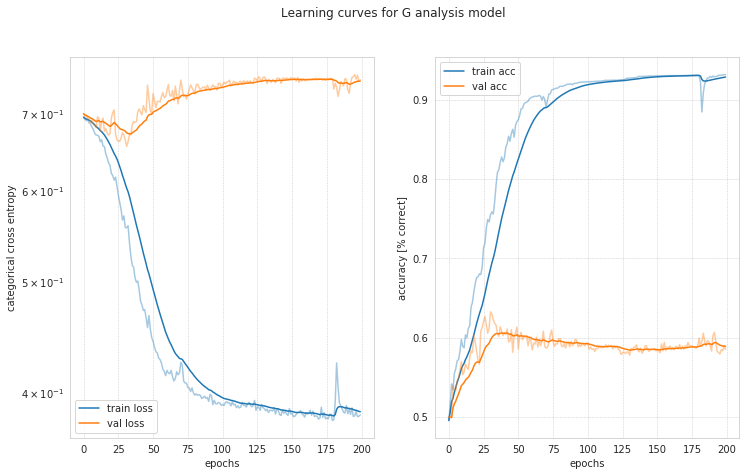

In [294]:
shadow_modelG = kindaResnetG(size_input_vector)

crit_fun = lambda input_, target : (input_, target)
y_hat_fun = lambda y: y.argmax(1)

loss_fun = nn.CrossEntropyLoss(g_shadow_target_weigths)
learning_rate = 0.005 #0.005
epochs = 200 #200

mt = ModelTrainer(shadow_modelG, loss_fun, optim.Adamax(shadow_modelG.parameters(), lr=learning_rate), y_hat_fun, crit_fun)
hist = mt.fit(g_shadow_train_dataset, g_shadow_test_dataset, epochs=epochs, batch_size=1000, verbose=epochs/20)
mt.plot_training("Learning curves for G analysis model")

In [295]:
sufix = 'resnetG_MNIST_conv1'

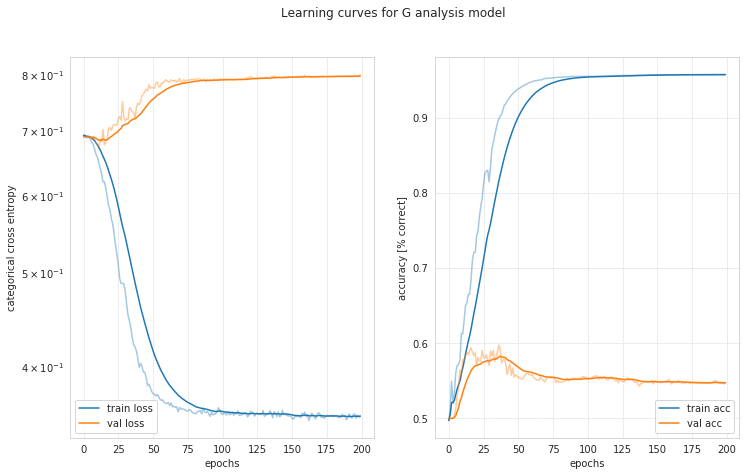

In [144]:
hist.plot("Learning curves for G analysis model")
plt.savefig("G_curve_" + sufix + ".png", dpi=300, bbox_inches='tight')

false negative percentage : 11.774325429272281
false positive percentage : 71.1297071129707


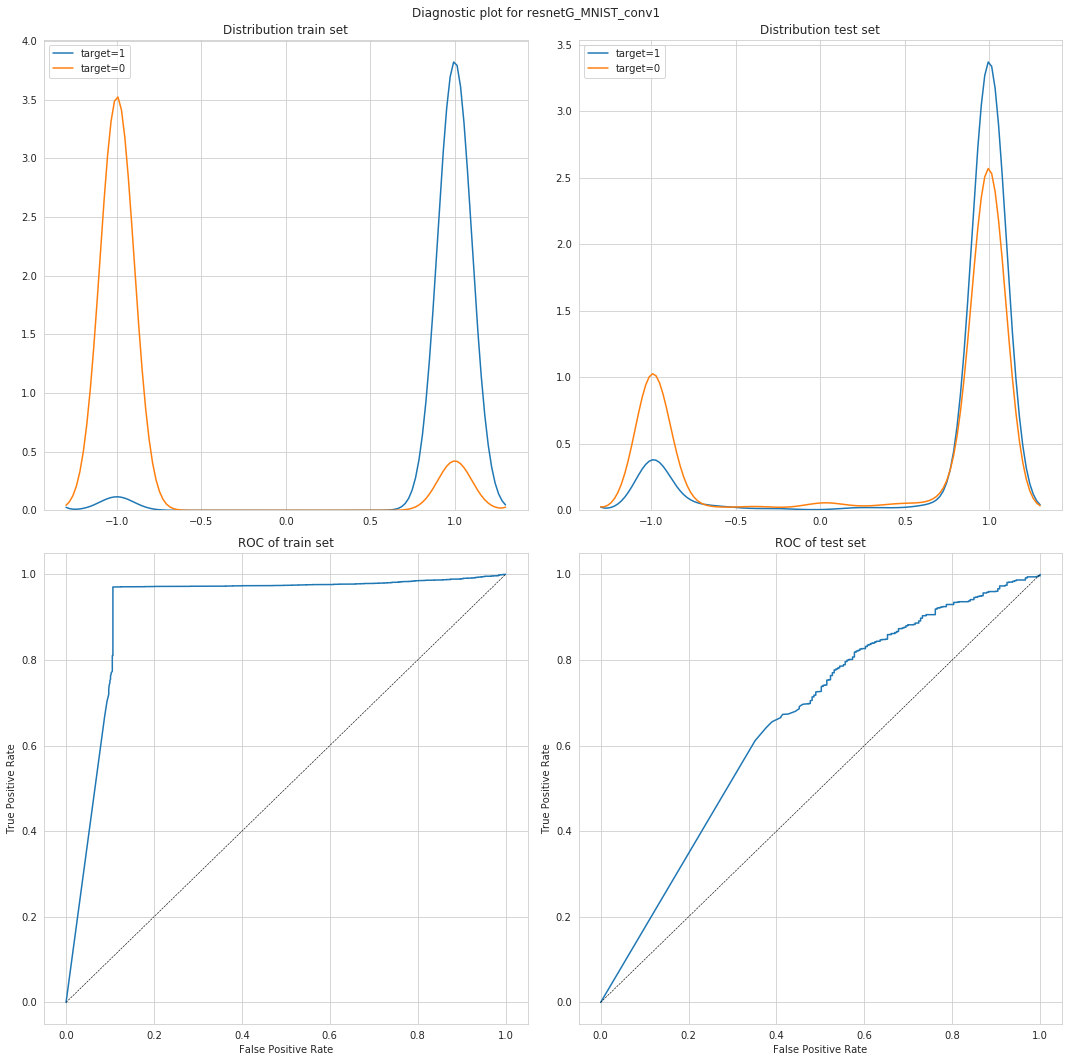


ROC score train : 0.9173362620955008
ROC score test : 0.6551487014919757


In [298]:
diagnostic_plots(shadow_modelG, [g_shadow_train_dataset], [g_shadow_test_dataset], dataset_name=sufix, bw=0.1, savefig=False)

## 4) Train G with shadow models (output)

In [299]:
for i in range(nb_shadow_models):
    shadow_models[i].eval()

In [300]:
shadow_models[0]

LeoNet(
  (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
  (mxp1): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (view): View(_, [-1])
  (fc1): Linear(in_features=576, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=10, bias=True)
)

In [301]:
layers = list()
layer_names = list()

for i in range(nb_shadow_models):
    layers.append(shadow_models[i].fc2)
    layer_names.append("shadow_model["+str(i)+"].fc2")

In [302]:
g_shadow_train_datasets, g_shadow_test_datasets = \
generate_dataset_g_per_class_from_shadows(shadow_models, shadow_train_datasets, shadow_test_datasets, layers, layer_names, split=0.8, nb_class=10)

In [303]:
g_shadow_test_datasets[0][1].shape

torch.Size([1462])

In [304]:
choosen_class = 0
g_shadow_train_dataset = g_shadow_train_datasets[choosen_class]
g_shadow_test_dataset = g_shadow_test_datasets[choosen_class]

g_shadow_train_dataset, g_shadow_test_dataset = normalize_data(g_shadow_train_dataset, g_shadow_test_dataset)

In [305]:
size_input_vector = g_shadow_train_dataset[0].shape
print("size of layer vector :", size_input_vector)
flattened_size = np.prod(np.array(g_shadow_train_dataset[0].shape[1:]))
print("size of flattened input (1 sample):", flattened_size)

size of layer vector : torch.Size([5441, 1, 10])
size of flattened input (1 sample): 10


In [306]:
g_shadow_target_weigths = torch.abs(1-computeClassesWeights(g_shadow_train_dataset[1]))
g_shadow_target_weigths# = torch.Tensor([0.90, 0.1])

tensor([0.8638, 0.1362])

In [307]:
def denseG(vector_size):
    model = nn.Sequential(
        View([-1]),
        nn.Linear(vector_size, 256),
        nn.ReLU(),
        nn.BatchNorm1d(256),
        nn.Dropout(0.5),

        nn.Linear(256, 128),
        nn.ReLU(),
        nn.BatchNorm1d(128),
        nn.Dropout(0.5),
        
        nn.Linear(128, 64),
        nn.ReLU(),
        nn.BatchNorm1d(64),
        nn.Dropout(0.3),
        
        nn.Linear(64, 32),
        nn.ReLU(),
        nn.BatchNorm1d(32),
        
        nn.Linear(32, 16),
        nn.ReLU(),
        nn.BatchNorm1d(16),
        
        nn.Linear(16, 2),
        nn.Softmax(1)
    )
    return model

def small_denseG(vector_size):
    model = nn.Sequential(
        View([-1]),
        nn.Linear(vector_size, 128),
        nn.ReLU(),
        nn.BatchNorm1d(128),
        
        nn.Linear(128, 2),
    )
    return model

In [308]:
sufix = "denseG_MNIST_output"

CRITICAL:root:Cannot load caffe2.python. Error: /opt/pytorch/pytorch/torch/lib/python3.6/site-packages/caffe2/python/caffe2_pybind11_state.cpython-36m-x86_64-linux-gnu.so: undefined symbol: _ZN5fLI6438FLAGS_caffe2_max_keep_on_shrink_memoryE


******************************** Train log ************************************
                     train loss       train acc        val loss         val acc
0                    0.71134058           0.499      0.70172966           0.501
100                  0.64332771           0.624      0.69930834           0.574
200                  0.61027980           0.652      0.71753615           0.568
300                  0.58823423           0.678      0.74388653           0.559
400                  0.56987298           0.688      0.78884739           0.558
500                  0.55479507           0.707      0.81930304           0.566
600                  0.53962191           0.717      0.81951076           0.563
700                  0.52554796           0.728      0.89695573           0.558
800                  0.51656270           0.733      0.89569020           0.571
900                  0.50215277           0.741      0.95166111           0.562
1000                 0.49290493         

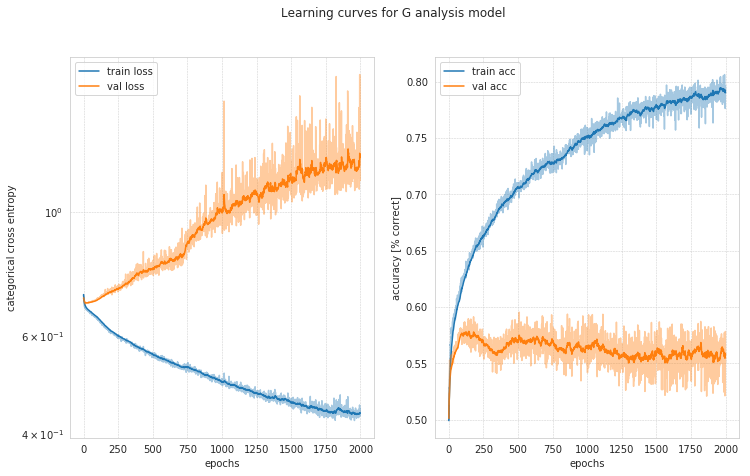

In [309]:
shadow_modelG = small_denseG(flattened_size)

crit_fun = lambda input_, target : (input_, target)
y_hat_fun = lambda y: y.argmax(1)

loss_fun = nn.CrossEntropyLoss(g_shadow_target_weigths)
learning_rate = 0.05
epochs = 2000

mt = ModelTrainer(shadow_modelG, loss_fun, optim.SGD(shadow_modelG.parameters(), lr=learning_rate), y_hat_fun, crit_fun)
hist = mt.fit(g_shadow_train_dataset, g_shadow_test_dataset, epochs=epochs, batch_size=1000, verbose=epochs/20)
plotted = mt.plot_training("Learning curves for G analysis model")

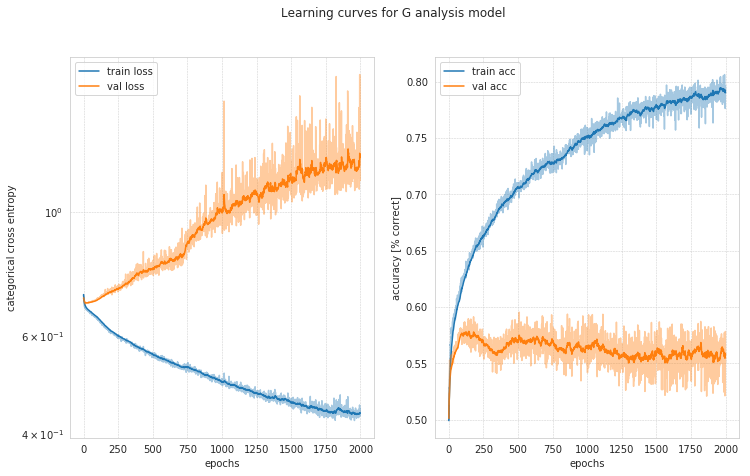

In [310]:
hist.plot("Learning curves for G analysis model")
plt.savefig("G_curve_" + sufix + ".png", dpi=300, bbox_inches='tight')

false negative percentage : 28.86345053147997
false positive percentage : 61.08786610878661


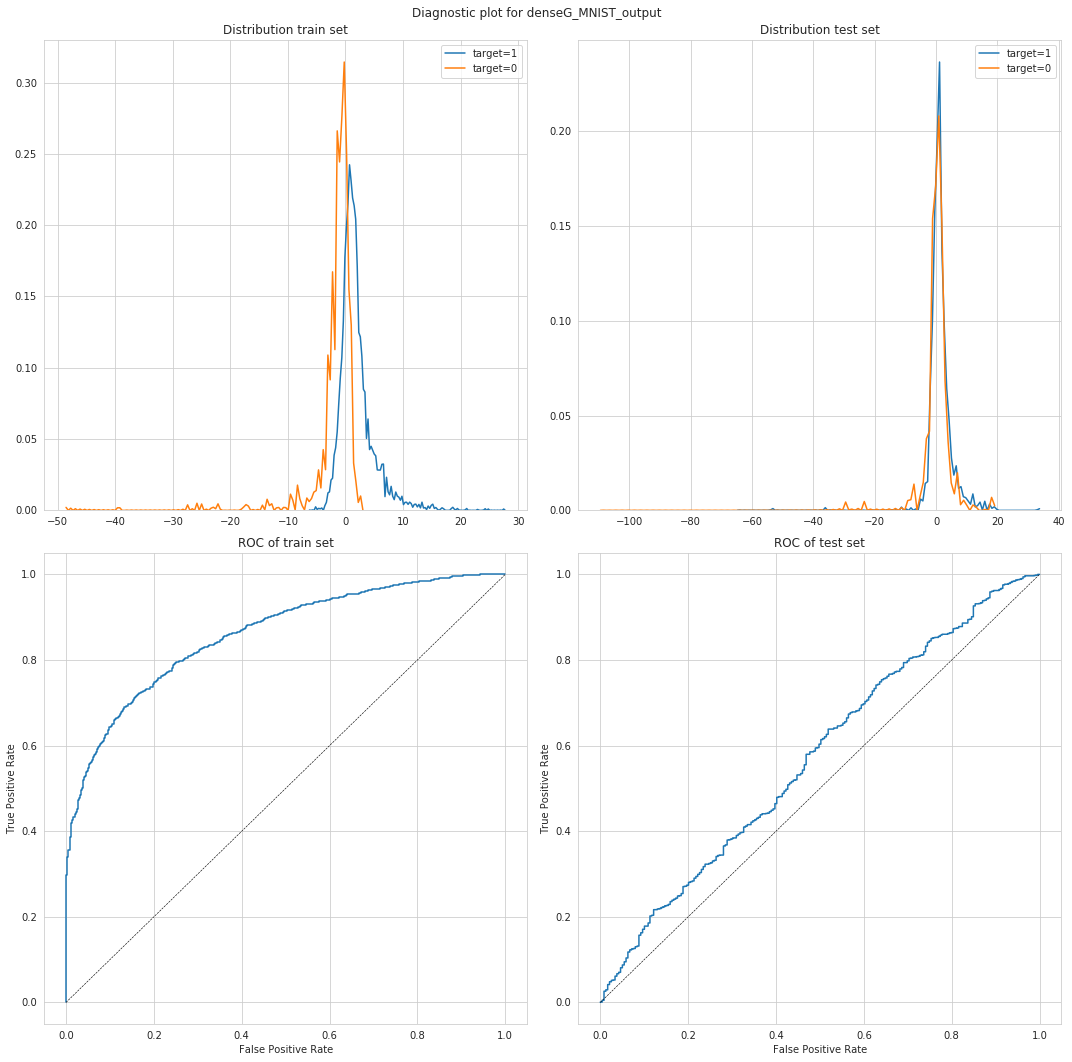


ROC score train : 0.8595526459356246
ROC score test : 0.5736237457106983


In [311]:
diagnostic_plots(shadow_modelG, [g_shadow_train_dataset], [g_shadow_test_dataset], bw=0.1, dataset_name=sufix,savefig=True)